# アクティブ・ノイズ・キャンセラー（ANC）ハンズオン

## 1. 準備：ライブラリと可視化関数  
ANC用の可視化関数です。これまでのデモと違い、**「誤差信号 $e(n)$」**が主役（きれいになった音）として扱われる点に注目してください。
+ 1段目（学習曲線）: ノイズが消えていく様子（＝残留ノイズの減少）。
+ 2段目（フィルタ係数）: ノイズ源からマイクまでの「音の伝わり方（経路）」を学習した結果です。
+ 3段目（波形）: 「騒音まみれのマイク入力」と「ANCで処理したきれいな音」を比較します。

In [1]:
# @title 1. システムの準備（ライブラリと可視化関数）
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import librosa
from IPython.display import Audio, display
import io

try:
    from google.colab import files
    IN_COLAB = True
except Exception:
    IN_COLAB = False

# --- 可視化用関数 (ANC仕様) ---
def plot_anc_results(error_log, w_est, primary_in, clean_out, fs):
    """
    error_log: 学習曲線 (残留ノイズパワー)
    w_est: 推定されたノイズ伝達経路
    primary_in: 騒音まみれのマイク入力 (Signal + Noise)
    clean_out: ANC処理後の出力 (Estimated Signal) ※これがe(n)です！
    """
    fig, axes = plt.subplots(3, 1, figsize=(12, 12), constrained_layout=True)

    # カラー設定 (統一)
    col_in  = '#1f77b4'   # 青 (入力/Primary)
    col_anti= '#ff7f0e'   # オレンジ (アンチノイズ/Filter Output)
    col_out = '#2ca02c'   # 緑 (出力/Error = Clean Signal)

    # --- 1段目: 学習曲線 ---
    ax1 = axes[0]
    window = 200
    if len(error_log) > window:
        smooth_curve = np.convolve(error_log, np.ones(window)/window, mode='valid')
        ax1.plot(smooth_curve, color='gray', linewidth=2, label='Residual Noise Power')
    else:
        ax1.plot(error_log, color='gray', alpha=0.6)

    ax1.set_title("1. Learning Curve (Noise Cancellation Process)", fontsize=14)
    ax1.set_ylabel("Squared Error (log scale)")
    ax1.set_xlabel("Iterations")
    ax1.grid(True, which="both", ls=':', alpha=0.7)
    ax1.legend(loc='upper right')

    # --- 2段目: フィルタ係数 (Noise Path Estimation) ---
    ax2 = axes[1]
    # ANCのフィルタは、参照マイクから主マイクへの「ノイズの通り道」を模倣します
    markerline, stemlines, baseline = ax2.stem(
        np.arange(len(w_est)), w_est,
        linefmt=col_anti, markerfmt='o', basefmt=" ", label='Estimated Noise Path'
    )
    plt.setp(stemlines, 'linewidth', 2, 'color', col_anti)
    plt.setp(markerline, 'markersize', 6, 'color', col_anti, 'markerfacecolor', col_anti)

    ax2.set_title("2. Filter Weights (Modeling the Noise Path)", fontsize=14)
    ax2.set_xlabel("Tap Index")
    ax2.set_ylabel("Value")
    ax2.grid(True, ls=':', alpha=0.7)
    ax2.legend(loc='upper right')

    # --- 3段目: 波形比較 ---
    ax3 = axes[2]
    n_samples = len(primary_in)
    plot_len = min(int(fs * 0.05), n_samples) # 最後の0.05秒
    time_axis = np.arange(n_samples - plot_len, n_samples) / fs

    # 騒音まみれの入力
    ax3.plot(time_axis, primary_in[-plot_len:], color=col_in, alpha=0.5, label='Primary Mic (Voice + Noise)')
    # きれいになった出力
    ax3.plot(time_axis, clean_out[-plot_len:], color=col_out, linewidth=2, label='ANC Output (Clean Voice)')

    ax3.set_title(f"3. Waveforms Comparison (Final {plot_len} samples)", fontsize=14)
    ax3.set_xlabel("Time [s]")
    ax3.set_ylabel("Amplitude")
    ax3.grid(True, ls=':', alpha=0.7)
    ax3.legend(loc='upper right')

    plt.suptitle("Active Noise Canceller Demo (ANC)", fontsize=20)
    plt.show()

print("準備完了。")

準備完了。


## 2. 音源の選択（シチュエーション設定）
ANCの典型的な応用例である **コックピットや工場での会話** をシミュレーションします。  

+ Target Signal (Voice): 守りたい「パイロットの声」。
+ Noise Source (Engine): 消したい「エンジンの轟音」。

※ここでのポイントは、マイクに入ってくるノイズは、元のノイズ源から **空気中を伝わって変化した（反響した）音** であるということです。

In [2]:
# @title 2. ソースデータの選択 (Signal & Noise Setup) { run: "auto" }

source_type = "Artificial Data" # @param ["Artificial Data", "Upload Audio"]
fs = 8000
duration = 5.0 # ★修正: 5秒に変更（効果をじっくり確認するため）

# --- 1. 守りたい信号 (Voice / Target) ---
if source_type == "Artificial Data":
    # 人工音声（のようなもの）
    t = np.linspace(0, duration, int(fs * duration))
    # 基本周波数200Hzの倍音成分を含む波形
    clean_voice = 0.5 * np.sin(2 * np.pi * 200 * t) + \
                  0.3 * np.sin(2 * np.pi * 400 * t) + \
                  0.1 * np.sin(2 * np.pi * 600 * t)
    # おしゃべりのようにOn/Offさせる
    envelope = (np.sin(2 * np.pi * 2 * t) > 0).astype(float)
    clean_voice = clean_voice * envelope
    print(f"人工データ(擬似音声)を生成しました (長さ: {duration}秒)")

elif source_type == "Upload Audio":
    print("音声をアップロードしてください（消えてほしくない『声』のファイル）")
    uploaded = files.upload()
    if len(uploaded) == 0:
        raise ValueError("ファイルがアップロードされませんでした。")

    filename = list(uploaded.keys())[0]
    y, _ = librosa.load(io.BytesIO(uploaded[filename]), sr=fs, mono=True)

    # ★修正: 最大5秒まで読み込む
    max_len = int(fs * 5.0)
    if len(y) > max_len:
        y = y[:max_len]
    else:
        # 短い場合は繰り返して5秒にする（デモ用）
        repeat_times = max_len // len(y) + 1
        y = np.tile(y, repeat_times)[:max_len]

    clean_voice = y / np.max(np.abs(y))
    print(f"ファイルを読み込みました: {filename}")

n_samples = len(clean_voice)


# --- 2. ノイズ源 (Reference Noise) ---
np.random.seed(1)
noise_source = np.random.randn(n_samples)


# --- 3. 実際に混ざるノイズ (Interference) ---
# Noise Path (空気中の伝達)
noise_path = np.array([0.8, 0.5, 0.2, -0.1, 0.05])
interference = signal.lfilter(noise_path, 1, noise_source)

# SNR調整
interference = interference / np.std(interference) * 0.5
clean_voice = clean_voice / np.std(clean_voice) * 0.5

# --- 4. メインマイク入力 (Primary Input) ---
primary_mic = clean_voice + interference

print("-" * 40)
print("▼ Clean Voice (Original) - これを取り出したい")
display(Audio(clean_voice, rate=fs))

print("▼ Noise Source (Reference) - エンジンの音")
display(Audio(noise_source, rate=fs))

print("▼ Primary Mic (Input) - うるさくて声が聞こえない！")
display(Audio(primary_mic, rate=fs))

人工データ(擬似音声)を生成しました (長さ: 5.0秒)
----------------------------------------
▼ Clean Voice (Original) - これを取り出したい


▼ Noise Source (Reference) - エンジンの音


▼ Primary Mic (Input) - うるさくて声が聞こえない！


## 3. ANCシミュレーション実行  
ここがANCの心臓部です。基本的な構造はLMSですが、**信号の流れ（ブロック図）**が少し違います。
+ Primary Input ($d$): 声 ＋ ノイズ
+ Reference Input ($x$): ノイズ源の音
+ Adaptive Filter ($W$): 参照ノイズ $x$ を加工して、マイクに届いたノイズ（干渉）を真似する「アンチノイズ $y$」を作ります。
+ Subtraction ($e = d - y$): マイク入力からアンチノイズを引き算します。
  + ノイズが消えれば、$e$ には「声」だけが残ります。
  + つまり、この $e$ こそが出力したい音声になります。

ANCを実行中... (Duration=5.0s, mu=0.0008)
完了。
----------------------------------------
Noise Reduction Performance (Latter half):
 - Noise Suppression: 16.81 dB
----------------------------------------


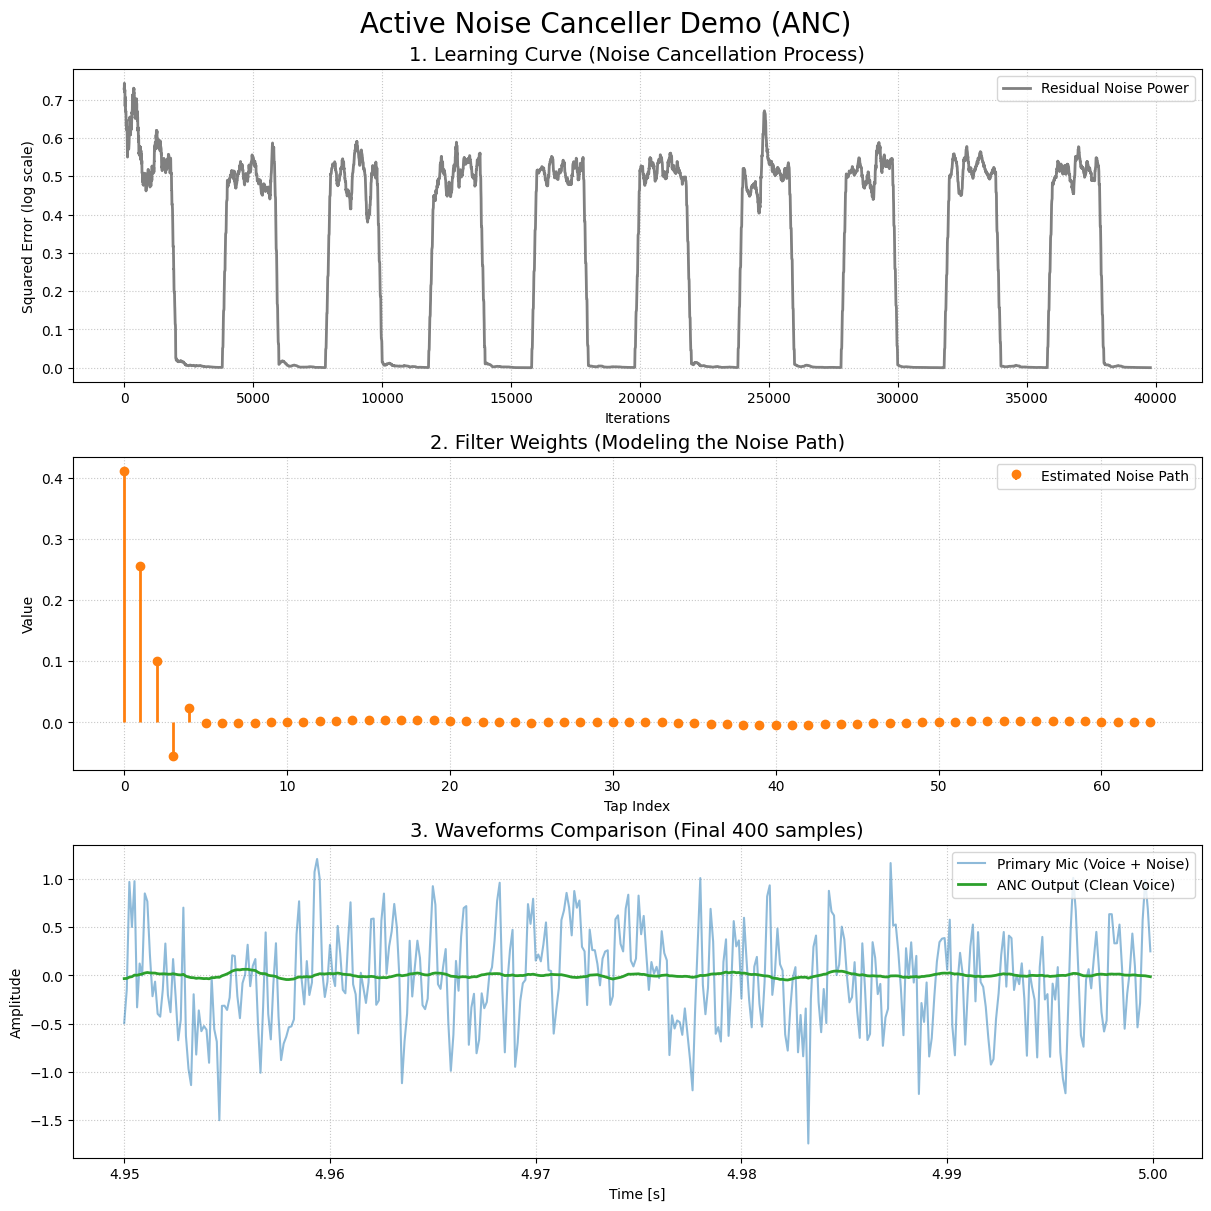


 聴き比べ (Sound Check)
1. Primary Mic (Input): うるさい状態


2. ANC Output (Result): 徐々にきれいになる音
   ★ここを聞いてください！最初はノイズがありますが、徐々に消えていきます


3. Anti-Noise (Internal): フィルタが作った『逆位相のノイズ』


In [3]:
# @title 3. ANCシミュレーション実行 { run: "auto" }

# --- パラメータ設定 ---
# フィルタ長
filter_order = 64 # @param {type:"slider", min:16, max:128, step:16}

# 学習率 (Step Size): ★修正: 最小値を0.0001にして、ゆっくりした学習を可能に
# 小さくするほど、ノイズが「スーッ」とゆっくり消えるようになります。
step_size_mu = 0.0008 # @param {type:"slider", min:0.0001, max:0.05, step:0.0001}

# --- ANCアルゴリズム (Standard LMS) ---
w = np.zeros(filter_order)
y_anti_noise = np.zeros(n_samples)
e_clean = np.zeros(n_samples)
error_log = []

# Reference信号バッファ
x_buffer = np.zeros(filter_order)

print(f"ANCを実行中... (Duration={duration}s, mu={step_size_mu})")

for n in range(n_samples):
    # 1. 参照ノイズ x(n)
    x_val = noise_source[n]

    # バッファ更新
    x_buffer = np.roll(x_buffer, 1)
    x_buffer[0] = x_val

    # 2. アンチノイズ生成 y(n)
    y_anti_noise[n] = np.dot(w, x_buffer)

    # 3. ノイズキャンセル (Subtraction) e(n) = d(n) - y(n)
    e_clean[n] = primary_mic[n] - y_anti_noise[n]

    # 4. 係数更新
    w = w + step_size_mu * e_clean[n] * x_buffer

    # 学習曲線用 (声の成分も含む出力パワー)
    error_log.append(e_clean[n]**2)

print("完了。")


# --- 性能評価 (Noise Reduction) ---
# 後半のデータ(安定後)で評価
eval_start = n_samples // 2

input_noise_power = np.mean((primary_mic[eval_start:] - clean_voice[eval_start:])**2)
output_noise_power = np.mean((e_clean[eval_start:] - clean_voice[eval_start:])**2)
reduction_db = 10 * np.log10(input_noise_power / output_noise_power)

print("-" * 40)
print(f"Noise Reduction Performance (Latter half):")
print(f" - Noise Suppression: {reduction_db:.2f} dB")
print("-" * 40)


# --- 結果表示 ---
plot_anc_results(error_log, w, primary_mic, e_clean, fs)

# 音声再生
print("\n" + "="*40)
print(" 聴き比べ (Sound Check)")
print("="*40)

print("1. Primary Mic (Input): うるさい状態")
display(Audio(primary_mic, rate=fs))

print("2. ANC Output (Result): 徐々にきれいになる音")
print("   ★ANCのポイント！最初はノイズがありますが、徐々に消えていきます")
display(Audio(e_clean, rate=fs))

print("3. Anti-Noise (Internal): フィルタが作った『逆位相のノイズ』")
display(Audio(y_anti_noise, rate=fs))

---
### License & Copyright
**This software is released under the MIT License.**

<small>
Copyright (c) 2026 OGAWA Tomomi (Tokyo Denki University)

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.
</small>

**Contact:** <small>to.ogawa[at]ms.dendai.ac.jp</small>